In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from src.models import rnn, lstm, bjrnn, cfrnn, copulaCPTS, dplstm, vanila_copula

from src.experiments.covid_exp import COVIDDataset

import logging
import datetime
from tabulate import tabulate

import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
def subtract_df(x, val):
    
    method_column = x.iloc[:,0]

    # Subtract val from each numeric value
    x_numeric_subtracted = x.iloc[:, 1:].sub(val)

    # Combine the Method column with the subtracted numeric values
    x_subtracted = pd.concat([method_column, x_numeric_subtracted], axis=1)
    
    return x_subtracted



# coverage data

cov90 = {
    "Method": ["Bonferroni", "Scheffe-JPR", "Boot-JPR(K=1)", "JANET-T(K=1)", "JANET-H(K=1)", 
               "Boot-JPR(K=2)", "JANET-T(K=2)", "JANET-H(K=2)", 
               "Boot-JPR(K=3)", "JANET-T(K=3)", "JANET-H(K=3)"],
    "H = 6": [91.7, 86.6, 88.7, 87.6, 88.7, 87.2, 88.9, 88.5, 88.2, 89.9, 88.9],
    "H = 12": [90.8, 85.9, 87.7, 88.0, 89.7, 87.5, 87.7, 88.6, 87.5, 87.9, 88.8],
    "H = 18": [91.1, 85.7, 88.0, 88.2, 89.3, 88.2, 89.1, 88.7, 87.6, 87.7, 88.5],
    "H = 24": [88.3, 85.7, 87.3, 87.9, 88.6, 87.3, 89.4, 87.9, 87.4, 88.7, 88.7]
}

dfcov90 = subtract_df(pd.DataFrame(cov90), 90)

cov80 = {
    "Method": ["Bonferroni", "Scheffe-JPR", "Boot-JPR(K=1)", "JANET-T(K=1)", "JANET-H(K=1)", 
               "Boot-JPR(K=2)", "JANET-T(K=2)", "JANET-H(K=2)", 
               "Boot-JPR(K=3)", "JANET-T(K=3)", "JANET-H(K=3)"],
    "H = 6": [86.0, 73.1, 79.4, 78.9, 79.5, 79.1, 79.6, 79.5, 78.7, 79.9, 78.3],
    "H = 12": [85.9, 71.5, 80.0, 79.2, 80.5, 77.5, 78.4, 79.3, 79.3, 80.5, 79.8],
    "H = 18": [85.2, 71.0, 80.1, 79.9, 81.4, 79.8, 79.9, 81.2, 78.6, 79.3, 79.5],
    "H = 24": [83.4, 70.8, 79.7, 79.3, 80.3, 78.6, 79.7, 78.6, 78.7, 80.2, 79.3]
}

dfcov80 = subtract_df(pd.DataFrame(cov80), 80)


cov70 = {
    "Method": ["Bonferroni", "Scheffe-JPR", "Boot-JPR(K=1)", "JANET-T(K=1)", "JANET-H(K=1)", 
               "Boot-JPR(K=2)", "JANET-T(K=2)", "JANET-H(K=2)", 
               "Boot-JPR(K=3)", "JANET-T(K=3)", "JANET-H(K=3)"],
    "H = 6": [82.3, 60.2, 69.6, 69.3, 69.8, 71.0, 69.4, 70.7, 68.8, 70.7, 68.8],
    "H = 12": [81.0, 57.5, 70.2, 69.3, 72.0, 68.9, 70.3, 71.1, 69.1, 71.3, 68.9],
    "H = 18": [77.5, 56.8, 70.3, 71.0, 72.1, 69.8, 71.4, 71.4, 70.0, 71.3, 70.6],
    "H = 24": [78.8, 56.5, 71.2, 71.2, 71.4, 69.4, 70.6, 69.8, 70.8, 70.9, 70.8]
}

dfcov70 = subtract_df(pd.DataFrame(cov70), 70)

# width data

wid90 = {
    "Method": ["Bonferroni", "Scheffe-JPR", "Boot-JPR(K=1)", "JANET-T(K=1)", "JANET-H(K=1)", 
               "Boot-JPR(K=2)", "JANET-T(K=2)", "JANET-H(K=2)", 
               "Boot-JPR(K=3)", "JANET-T(K=3)", "JANET-H(K=3)"],
    "H = 6": [7.73, 7.98, 7.69, 7.44, 7.60, 6.17, 6.04, 6.13, 4.88, 4.78, 4.83],
    "H = 12": [9.51, 10.83, 9.73, 9.50, 9.71, 8.12, 7.98, 8.09, 6.87, 6.75, 6.83],
    "H = 18": [10.45, 12.83, 10.87, 10.64, 10.95, 9.18, 9.05, 9.19, 7.97, 7.82, 7.94],
    "H = 24": [10.94, 14.41, 11.66, 11.40, 11.76, 9.89, 9.74, 9.96, 8.61, 8.56, 8.69]
}

dfwid90 = pd.DataFrame(wid90)

wid80 = {
    "Method": ["Bonferroni", "Scheffe-JPR", "Boot-JPR(K=1)", "JANET-T(K=1)", "JANET-H(K=1)", 
               "Boot-JPR(K=2)", "JANET-T(K=2)", "JANET-H(K=2)", 
               "Boot-JPR(K=3)", "JANET-T(K=3)", "JANET-H(K=3)"],
    "H = 6": [6.89, 6.61, 6.59, 6.41, 6.53, 5.23, 5.13, 5.19, 4.08, 4.00, 4.03],
    "H = 12": [8.73, 9.25, 8.56, 8.33, 8.47, 7.12, 7.00, 7.07, 6.00, 5.93, 5.96],
    "H = 18": [9.64, 11.14, 9.66, 9.45, 9.63, 8.19, 8.06, 8.14, 7.08, 6.99, 7.04],
    "H = 24": [10.26, 12.64, 10.47, 10.20, 10.44, 8.89, 8.76, 8.88, 7.79, 7.72, 7.78]
}

dfwid80 = pd.DataFrame(wid80)

wid70 = {
    "Method": ["Bonferroni", "Scheffe-JPR", "Boot-JPR(K=1)", "JANET-T(K=1)", "JANET-H(K=1)", 
               "Boot-JPR(K=2)", "JANET-T(K=2)", "JANET-H(K=2)", 
               "Boot-JPR(K=3)", "JANET-T(K=3)", "JANET-H(K=3)"],
    "H = 6": [6.38, 5.67, 5.86, 5.70, 5.78, 4.60, 4.51, 4.57, 3.53, 3.48, 3.49],
    "H = 12": [8.22, 8.15, 7.73, 7.55, 7.64, 6.41, 6.32, 6.35, 5.42, 5.32, 5.36],
    "H = 18": [8.96, 9.96, 8.81, 8.64, 8.76, 7.47, 7.37, 7.41, 6.48, 6.39, 6.43],
    "H = 24": [9.79, 11.40, 9.63, 9.38, 9.54, 8.21, 8.08, 8.16, 7.20, 7.13, 7.17]
}

dfwid70 = pd.DataFrame(wid70)


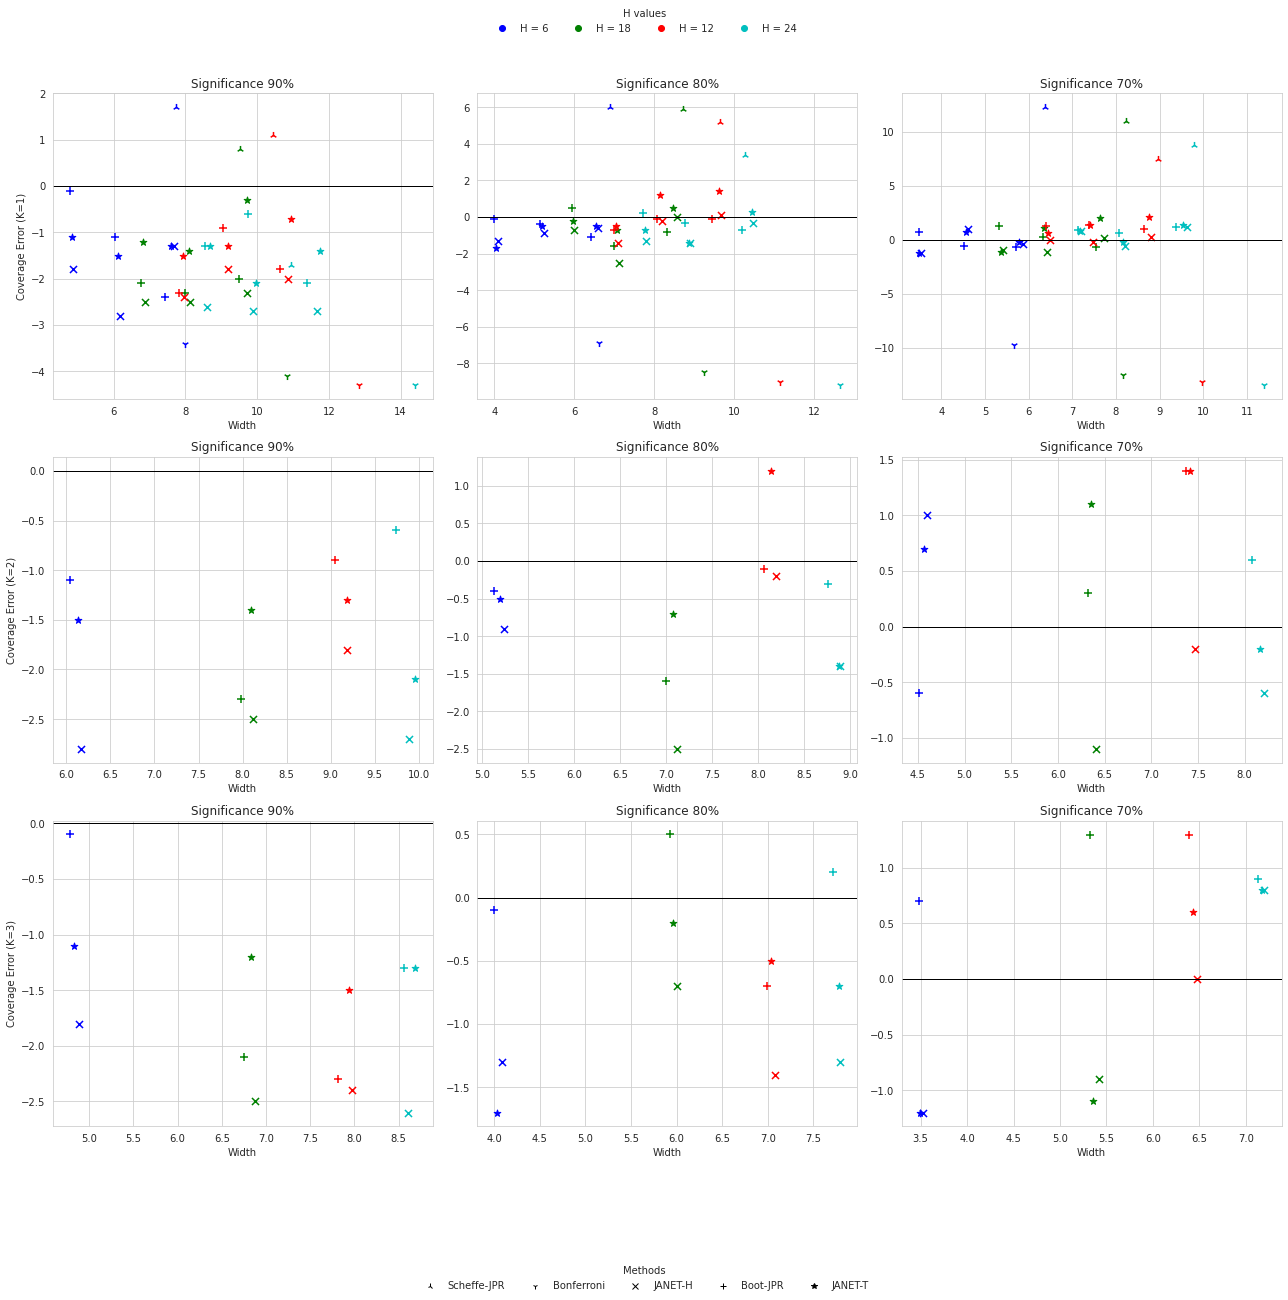

In [25]:
colors = {
    "H = 6": 'b',
    "H = 12": 'g',
    "H = 18": 'r',
    "H = 24": 'c',
}

# Define markers for each method group
markers = {
    "Bonferroni": 'o',
    "Scheffe-JPR": '^',
    "Boot-JPR": 's',
    "JANET-T": 'P',
    "JANET-H": 'D',
}

markers = {
    "Bonferroni": '2',
    "Scheffe-JPR": '1',
    "Boot-JPR": 'x',
    "JANET-T": '+',
    "JANET-H": '*',
}

# Combine data into a dictionary for easier iteration
data = {
    '90%': {'coverage': dfcov90, 'width': dfwid90},
    '80%': {'coverage': dfcov80, 'width': dfwid80},
    '70%': {'coverage': dfcov70, 'width': dfwid70},
}

# Function to filter methods based on K value
def filter_methods(df, k_value):
    if k_value == 1:
        return df
    return df[df['Method'].str.contains(f'(K={k_value})')]

# Function to get the base method name without K value
def get_base_method_name(method):
    for base in markers.keys():
        if base in method:
            return base
    return method

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

# Store handles for the legends
handles_shapes = []
labels_shapes = set()
handles_colors = []
labels_colors = set()

# Initialize lists to collect all data points for setting limits
all_coverage_errors = []
all_widths = []

for col_idx, (level, dfs) in enumerate(data.items()):
    for row_idx, k in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        df_cov = filter_methods(dfs['coverage'], k)
        df_wid = filter_methods(dfs['width'], k)
        
        for method in df_cov['Method']:
            for h in colors.keys():
                # Extract coverage errors and widths for the method and H value
                coverage_errors = df_cov[df_cov['Method'] == method][h].values
                widths = df_wid[df_wid['Method'] == method][h].values
                
                # Collect data points for setting axis limits
                all_coverage_errors.extend(coverage_errors)
                all_widths.extend(widths)
                
                # Get the base method name for consistent markers
                base_method = get_base_method_name(method)
                
                # Plot each method with its specific color and marker
                scatter = ax.scatter(widths, coverage_errors, 
                           color=colors[h], marker=markers[base_method], s=50.2)
                
                # Add to legend handles if not already added
                if base_method not in labels_shapes:
                    handles_shapes.append(plt.Line2D([0], [0], marker=markers[base_method], color='k', linestyle=''))
                    labels_shapes.add(base_method)
                
                if h not in labels_colors:
                    handles_colors.append(plt.Line2D([0], [0], marker='o', color=colors[h], linestyle=''))
                    labels_colors.add(h)
        
        ax.set_title(f'Significance {level}')
        ax.set_xlabel('Width')
        if col_idx == 0:
            ax.set_ylabel(f'Coverage Error (K={k})')
        ax.axhline(0, color='black', linewidth=1.)
        
        # Add grid lines
        ax.grid(True)

# Set the same x and y limits for all subplots
#x_min, x_max = min(all_widths), max(all_widths)
#y_min, y_max = min(all_coverage_errors), max(all_coverage_errors)
#for ax in axes.flat:
#    ax.set_xlim(x_min, x_max)
#    ax.set_ylim(y_min, y_max)

# Adding a single legend for shapes (methods) at the bottom
fig.legend(handles_shapes, labels_shapes, loc='lower center', ncol=6, title='Methods', frameon=False)

# Adding a single legend for colors (H values) at the bottom
fig.legend(handles_colors, labels_colors, loc='upper center', ncol=4, title='H values', frameon=False)

# Adjust layout for readability
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

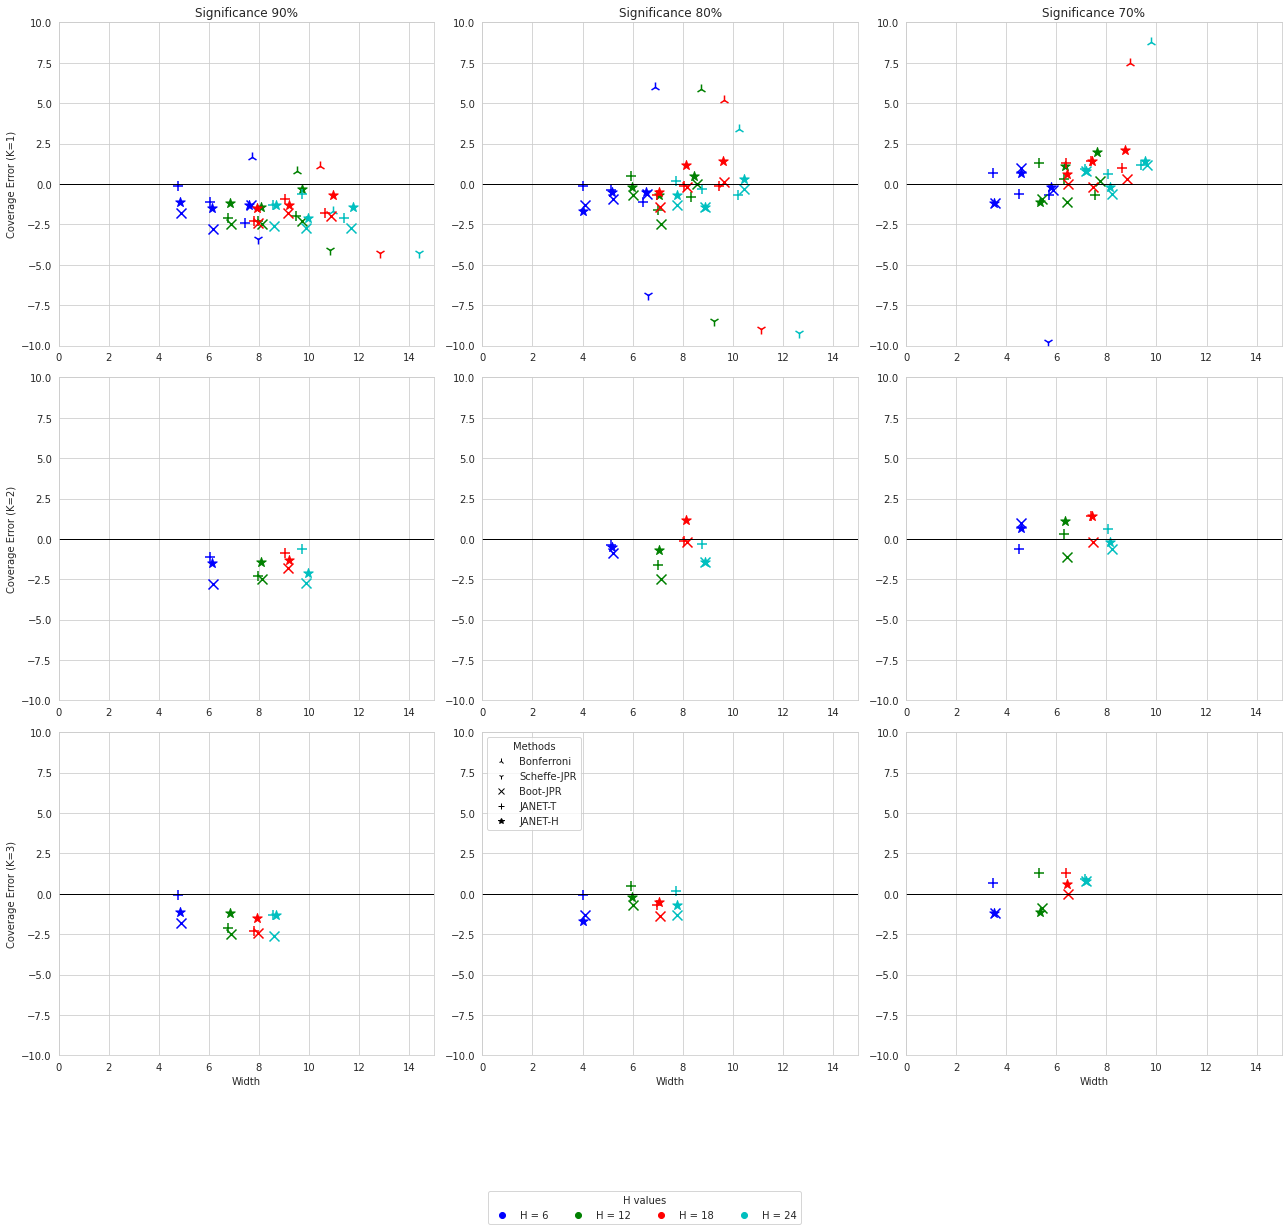

In [31]:
colors = {
    "H = 6": 'b',
    "H = 12": 'g',
    "H = 18": 'r',
    "H = 24": 'c',
}

markers = {
    "Bonferroni": '2',
    "Scheffe-JPR": '1',
    "Boot-JPR": 'x',
    "JANET-T": '+',
    "JANET-H": '*',
}

# Combine data into a dictionary for easier iteration
data = {
    '90%': {'coverage': dfcov90, 'width': dfwid90},
    '80%': {'coverage': dfcov80, 'width': dfwid80},
    '70%': {'coverage': dfcov70, 'width': dfwid70},
}

# Function to filter methods based on K value
def filter_methods(df, k_value):
    if k_value == 1:
        return df
    return df[df['Method'].str.contains(f'(K={k_value})')]

# Create subplots using Matplotlib
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

# Set shared limits for x and y axes across all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlim(0, 15)
        ax.set_ylim(-10, 10)

# Iterate through data and plot on subplots
for col_idx, (level, dfs) in enumerate(data.items()):
    for row_idx, k in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        df_cov = filter_methods(dfs['coverage'], k)
        df_wid = filter_methods(dfs['width'], k)
        
        for method in df_cov['Method']:
            for h in colors.keys():
                # Extract coverage errors and widths for the method and H value
                coverage_errors = df_cov[df_cov['Method'] == method][h].values
                widths = df_wid[df_wid['Method'] == method][h].values
                
                # Get the base method name for consistent markers
                base_method = method.split('(')[0]
                
                # Plot each method with its specific color and marker
                ax.scatter(widths, coverage_errors, color=colors[h], marker=markers[base_method], s=100, label=f'{base_method} ({k})')
                
        ax.set_title(f'Significance {level}' if row_idx == 0 else '')
        ax.set_xlabel('Width' if row_idx == 2 else '')
        if col_idx == 0:
            ax.set_ylabel(f'Coverage Error (K={k})')
        ax.axhline(0, color='black', linewidth=1.)
        
        # Add grid lines
        ax.grid(True)

# Adjust legends for markers (methods)
method_handles = []
method_labels = []
for method, marker in markers.items():
    method_handles.append(plt.Line2D([0], [0], marker=marker, color='k', linestyle=''))
    method_labels.append(method)
axes[2, 1].legend(method_handles, method_labels, loc='upper left', title='Methods')

# Adding a legend for colors (H values)
color_handles = []
color_labels = []
for color, value in colors.items():
    color_handles.append(plt.Line2D([0], [0], marker='o', color=value, linestyle=''))
    color_labels.append(color)
fig.legend(color_handles, color_labels, loc='lower center', ncol=4, title='H values')

# Adjust layout for readability
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

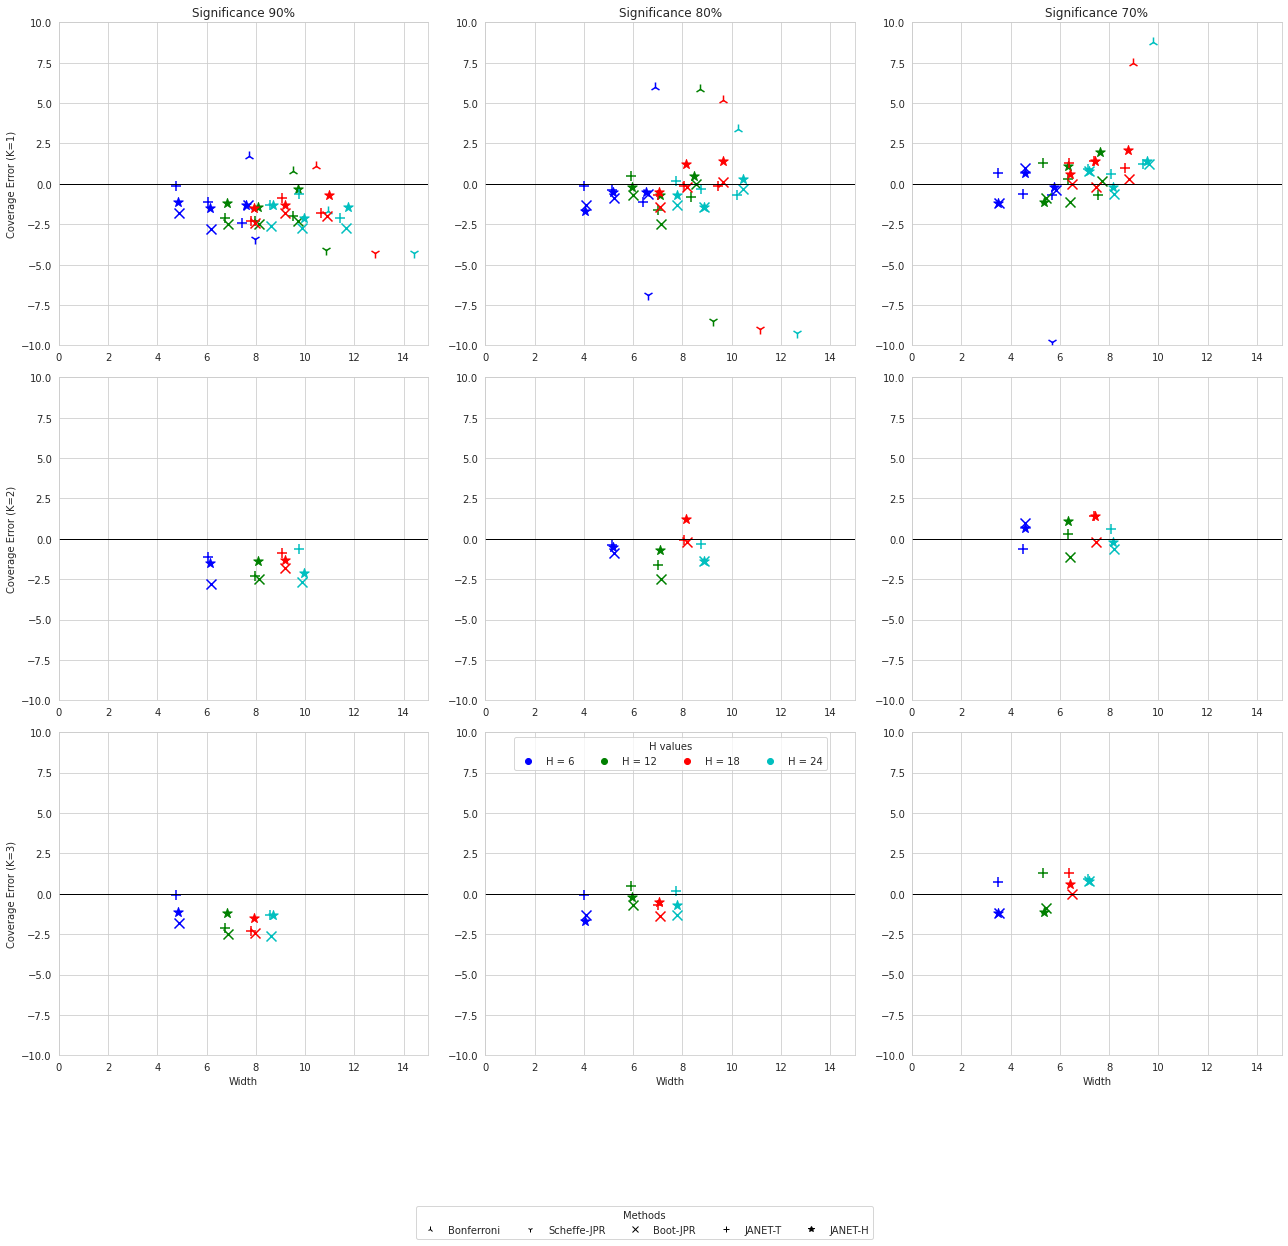

In [34]:
colors = {
    "H = 6": 'b',
    "H = 12": 'g',
    "H = 18": 'r',
    "H = 24": 'c',
}

markers = {
    "Bonferroni": '2',
    "Scheffe-JPR": '1',
    "Boot-JPR": 'x',
    "JANET-T": '+',
    "JANET-H": '*',
}

# Combine data into a dictionary for easier iteration
data = {
    '90%': {'coverage': dfcov90, 'width': dfwid90},
    '80%': {'coverage': dfcov80, 'width': dfwid80},
    '70%': {'coverage': dfcov70, 'width': dfwid70},
}

# Function to filter methods based on K value
def filter_methods(df, k_value):
    if k_value == 1:
        return df
    return df[df['Method'].str.contains(f'(K={k_value})')]

# Create subplots using Matplotlib
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

# Set shared limits for x and y axes across all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlim(0, 15)
        ax.set_ylim(-10, 10)

# Iterate through data and plot on subplots
for col_idx, (level, dfs) in enumerate(data.items()):
    for row_idx, k in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        df_cov = filter_methods(dfs['coverage'], k)
        df_wid = filter_methods(dfs['width'], k)
        
        for method in df_cov['Method']:
            for h in colors.keys():
                # Extract coverage errors and widths for the method and H value
                coverage_errors = df_cov[df_cov['Method'] == method][h].values
                widths = df_wid[df_wid['Method'] == method][h].values
                
                # Get the base method name for consistent markers
                base_method = method.split('(')[0]
                
                # Plot each method with its specific color and marker
                ax.scatter(widths, coverage_errors, color=colors[h], marker=markers[base_method], s=100, label=f'{base_method} ({k})')
                
        ax.set_title(f'Significance {level}' if row_idx == 0 else '')
        ax.set_xlabel('Width' if row_idx == 2 else '')
        if col_idx == 0:
            ax.set_ylabel(f'Coverage Error (K={k})')
        ax.axhline(0, color='black', linewidth=1.)
        
        # Add grid lines
        ax.grid(True)

# Adjust legends for methods
method_handles = []
method_labels = []
for method, marker in markers.items():
    method_handles.append(plt.Line2D([0], [0], marker=marker, color='k', linestyle=''))
    method_labels.append(method)

# Adding a legend for colors (H values) below the grid
color_handles = []
color_labels = []
for color, value in colors.items():
    color_handles.append(plt.Line2D([0], [0], marker='o', color=value, linestyle=''))
    color_labels.append(color)
axes[2, 1].legend(color_handles, color_labels, loc='upper center', ncol=4, title='H values')

# Adjust layout for readability
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Adding the methods legend below the colors legend
fig.legend(method_handles, method_labels, loc='upper center', ncol=5, title='Methods', bbox_to_anchor=(0.5, 0.02))

plt.show()

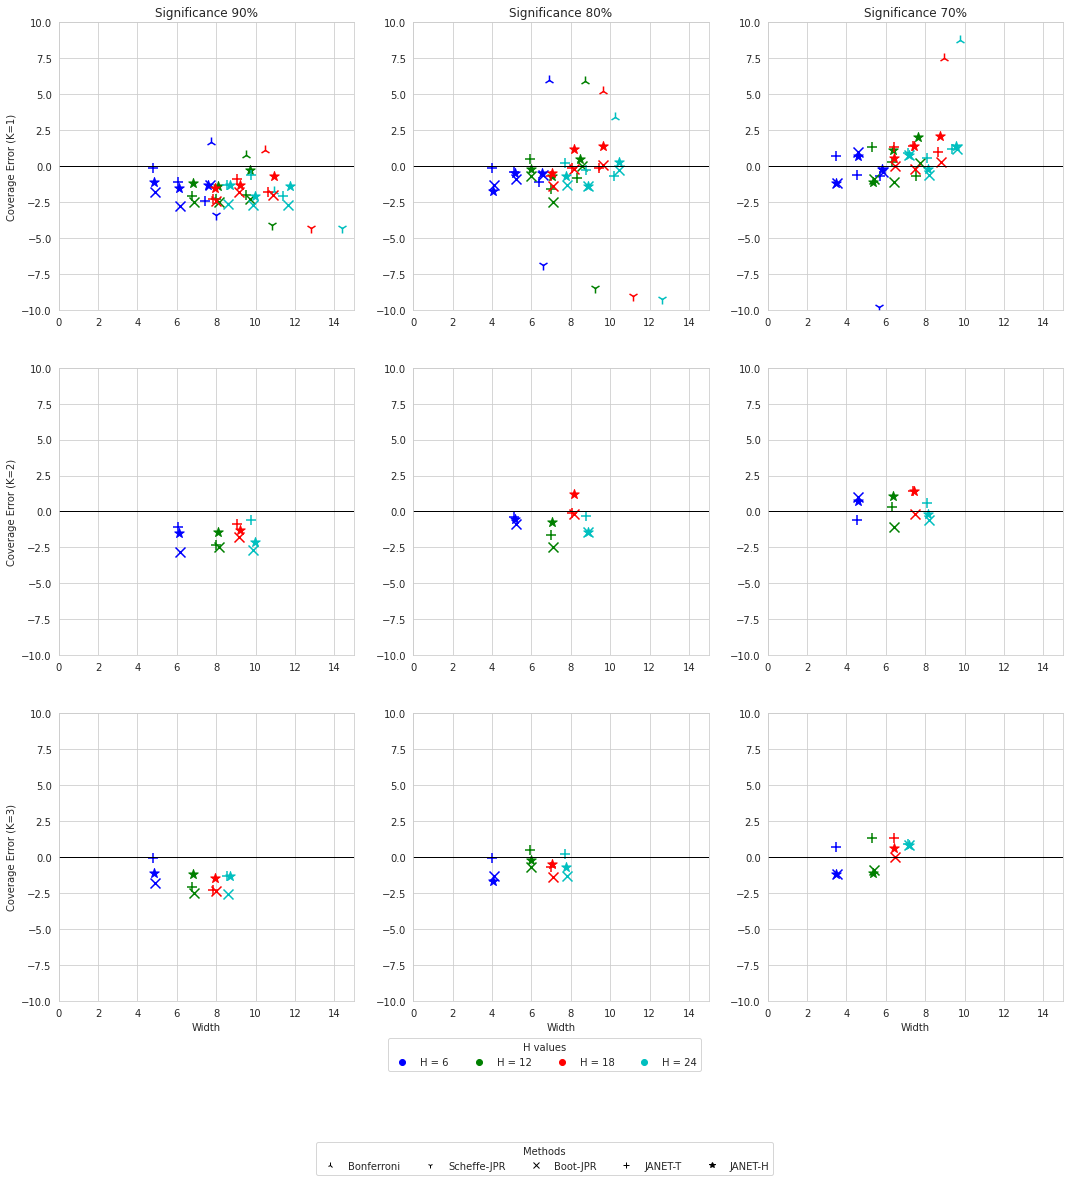

In [36]:
colors = {
    "H = 6": 'b',
    "H = 12": 'g',
    "H = 18": 'r',
    "H = 24": 'c',
}

markers = {
    "Bonferroni": '2',
    "Scheffe-JPR": '1',
    "Boot-JPR": 'x',
    "JANET-T": '+',
    "JANET-H": '*',
}

# Combine data into a dictionary for easier iteration
data = {
    '90%': {'coverage': dfcov90, 'width': dfwid90},
    '80%': {'coverage': dfcov80, 'width': dfwid80},
    '70%': {'coverage': dfcov70, 'width': dfwid70},
}

# Function to filter methods based on K value
def filter_methods(df, k_value):
    if k_value == 1:
        return df
    return df[df['Method'].str.contains(f'(K={k_value})')]

# Create subplots using Matplotlib
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

# Set shared limits for x and y axes across all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlim(0, 15)
        ax.set_ylim(-10, 10)

# Iterate through data and plot on subplots
for col_idx, (level, dfs) in enumerate(data.items()):
    for row_idx, k in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        df_cov = filter_methods(dfs['coverage'], k)
        df_wid = filter_methods(dfs['width'], k)
        
        for method in df_cov['Method']:
            for h in colors.keys():
                # Extract coverage errors and widths for the method and H value
                coverage_errors = df_cov[df_cov['Method'] == method][h].values
                widths = df_wid[df_wid['Method'] == method][h].values
                
                # Get the base method name for consistent markers
                base_method = method.split('(')[0]
                
                # Plot each method with its specific color and marker
                ax.scatter(widths, coverage_errors, color=colors[h], marker=markers[base_method], s=100, label=f'{base_method} ({k})')
                
        ax.set_title(f'Significance {level}' if row_idx == 0 else '')
        ax.set_xlabel('Width' if row_idx == 2 else '')
        if col_idx == 0:
            ax.set_ylabel(f'Coverage Error (K={k})')
        ax.axhline(0, color='black', linewidth=1.)
        
        # Add grid lines
        ax.grid(True)

# Adjust legends for methods
method_handles = []
method_labels = []
for method, marker in markers.items():
    method_handles.append(plt.Line2D([0], [0], marker=marker, color='k', linestyle=''))
    method_labels.append(method)

# Adding a legend for colors (H values) below the grid
color_handles = []
color_labels = []
for color, value in colors.items():
    color_handles.append(plt.Line2D([0], [0], marker='o', color=value, linestyle=''))
    color_labels.append(color)

# Manually adjust the position of legends
plt.subplots_adjust(hspace=0.2)  # Reduce gap between subplots
fig.legend(color_handles, color_labels, loc='upper center', ncol=4, title='H values', bbox_to_anchor=(0.5, 0.1))  # Manually place colors legend
fig.legend(method_handles, method_labels, loc='upper center', ncol=5, title='Methods', bbox_to_anchor=(0.5, 0.02))  # Manually place methods legend

plt.show()